<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Пословная-токенизация">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Пословная токенизация
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-слов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация слов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Формирование-датасета">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Формирование датасета
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Построение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Построение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Обучение-модели">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.5-Генерация-текста">
                            <span class="toc-item-num">3.5&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Simple RNN (посимвольная)

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. RNN с пословной токенизацией (текущий файл)
3. [Однонаправленная LSTM + BPE](unidirectional_LSTM_BPE.ipynb)
4. [Двунаправленная LSTM](bidirectional_LSTM.ipynb)
5. [Архитектура GPT](GPT_architecture.ipynb)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow import keras

import keras.layers as l

from keras import callbacks, losses, utils

# custom funcs
import utils.web_scrapping as web
import utils.process_checking as check
import utils.data_preprocessing as data_prep
import utils.charts_plotting as chart
import utils.predictions_making as pred

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Формирование/загрузка набора данных в зависимости от его наличия:

In [2]:
data = web.load_data('https://hpmor.ru/', 'hpmor.txt')

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [3]:
data[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов и предложений в тексте:

In [4]:
check.print_total(data)

Всего слов: 559791
Всего предложений: 37351


Разделение текста на отдельные предложения:

In [5]:
data_sentences = data_prep.split_into_sentences(data, '[^а-яА-ЯёЁ ,-]')

Выведение на экран начала текста:

In [6]:
data_sentences[:5]

['гарри поттер и методы рационального мышления',
 'элиезер юдковский',
 'петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду',
 'у него были частные учителя, дискуссии с отцом, а главное  книги, сотни и тысячи научных и фантастических книг',
 'в  лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами']

Сокращение количества предложений для обеспечения работы модели:

In [7]:
data_sentences = data_sentences[:5000]

Выведение на экран количества слов в уменьшенном тексте:

In [8]:
check.print_total(' '.join(data_sentences))

Всего слов: 68153


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Пословная токенизация

### 3.1 Токенизация слов

Получение словаря уникальных слов текста:

In [9]:
vocabulary = np.array(sorted(set(' '.join(data_sentences).split(' '))))

Выведение на экран уникальных слов текста:

In [10]:
vocabulary

array(['', ',', '-', ..., 'ёкнуло', 'ёмкостей', 'ёрзал'], dtype='<U46')

Формирование словаря токенов:

In [11]:
tokenizer_word_to_index = {char: i for i, char in enumerate(vocabulary)}
tokenizer_index_to_word = {i: char for i, char in enumerate(vocabulary)}

Выведение на экран количества токенов в словаре:

In [12]:
print('Всего слов:', len(tokenizer_word_to_index))

Всего слов: 16852


Выведение на экран начала словаря токенов:

In [13]:
check.print_tokenizer_vocabulary(tokenizer_word_to_index)

[('', 0),
 (',', 1),
 ('-', 2),
 ('--', 3),
 ('--,', 4),
 ('-го', 5),
 ('-й', 6),
 ('-летние', 7),
 ('-теста,', 8),
 ('-часовой', 9)]

выведение на экран начала словаря токенов:

In [14]:
check.print_tokenizer_vocabulary(tokenizer_index_to_word)

[(0, ''),
 (1, ','),
 (2, '-'),
 (3, '--'),
 (4, '--,'),
 (5, '-го'),
 (6, '-й'),
 (7, '-летние'),
 (8, '-теста,'),
 (9, '-часовой')]

---

### 3.2 Формирование датасета

Преобразование текста в вектор на основе токенов:

In [15]:
vector = np.array([tokenizer_word_to_index[word] for word in ' '.join(data_sentences).split()])

Выведение на экран части исходного текста и его векторного представления:

In [16]:
check.print_init_vector(data, vector)

Исходный текст:
 гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не 

Векторное представление:
 [ 2100 10578  4368  6288 12371  6598 16712 16781  9250  2041  3844  7112
  3456  3212    10  3456 15483 11685  4368  2100 10256   742  2337   513
   431 14090 15094  7203   720 16223 15760  2836 12634  8826    10  2160
  5130 13862  4368 15057  7039  4368 15837  5120   742  5689  2100  4284
 12634  5011  6292  5150 11809 14738   931  4368  3145  1000  7579  2100
  7112 11642  1732 15094  7203  3307  3564 15081 14268  5369 16805  6767
 12813  8743  6620  3267  6596    48 10781  4844  9264 12602  4494  3311
   742 11711  6844  2100 10578  4368  6288 12371  6598  3855  9056  6240
  9394 10302   742  6363]


Формирование набора данных из срезов вектора текста:

In [17]:
vector = Dataset.from_tensor_slices(vector)

Задание констант:

In [18]:
VOCAB_LEN = len(tokenizer_word_to_index.items())
BATCH_SIZE = 32

Формирование последовательностей по заданному количеству символов:

In [19]:
sequences = vector.batch(BATCH_SIZE, drop_remainder=True) 

Задание констант:

In [20]:
BATCHES_PER_EPOCH = len(sequences) // BATCH_SIZE

Формирование датасета:

In [21]:
dataset = sequences.map(data_prep.get_features_target)

Выведение на экран первой входящей последовательности и соответствующего ей сдвига:

In [22]:
for features, target in dataset.take(1):
    check.print_single_element(features.numpy(), target.numpy(), tokenizer_index_to_word, False)

Признаки (31,):
[ 2100 10578  4368  6288 12371  6598 16712 16781  9250  2041  3844  7112
  3456  3212    10  3456 15483 11685  4368  2100 10256   742  2337   513
   431 14090 15094  7203   720 16223 15760]

Перевод в текст:
гарри поттер и методы рационального мышления элиезер юдковский петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду у него были частные учителя,

Целевой признак (31,):
[10578  4368  6288 12371  6598 16712 16781  9250  2041  3844  7112  3456
  3212    10  3456 15483 11685  4368  2100 10256   742  2337   513   431
 14090 15094  7203   720 16223 15760  2836]

Перевод в текст:
поттер и методы рационального мышления элиезер юдковский петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду у него были частные учителя, дискуссии



Формирование датасета с делением на батчи:

In [23]:
data = dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)

Выведение на экран размерностей первой входящей последовательности и соответствующего ей сдвига:

In [24]:
for features, target in data.take(1):
    check.print_single_dimension(features, target)

Размерность признаков: (32, 31)
Размерность целевого признака: (32, 31)


---

### 3.3 Построение модели

Задание модели:

In [25]:
model = keras.Sequential([
    l.Embedding(VOCAB_LEN, BATCH_SIZE, batch_input_shape=[BATCH_SIZE, None]),
    l.Bidirectional(l.LSTM(150, return_sequences = True)),
    l.Dropout(0.2),
    l.LSTM(100, return_sequences=True, stateful=True),
    l.Dense(VOCAB_LEN / 2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    l.Dense(VOCAB_LEN)
])

Выведение на экран таблицы поведения параметров на словях нейросети:

In [26]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 32)            539264    
                                                                 
 bidirectional (Bidirectiona  (32, None, 300)          219600    
 l)                                                              
                                                                 
 dropout (Dropout)           (32, None, 300)           0         
                                                                 
 lstm_1 (LSTM)               (32, None, 100)           160400    
                                                                 
 dense (Dense)               (32, None, 8426)          851026    
                                                                 
 dense_1 (Dense)             (32, None, 16852)         142011804 
                                                        

Проверка наличия папки для хранения изображений:

In [27]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

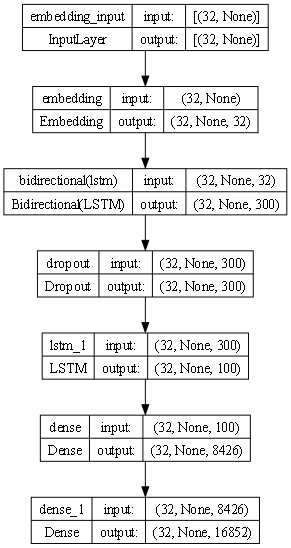

In [28]:
utils.plot_model(model, 'images/rnn_word_model.png', show_shapes=True, dpi=70)

Проверка модели на восприятие датасета на примере первой последовательности:

In [29]:
for features, target in data.take(1):
    check.print_single_test(model, features, target, tokenizer_index_to_word)

Размерность признаков: (32, 31)
Размерность предсказаний: (32, 31, 16852)
Размерность тензора с 1 индексом классов (31, 1)
Предсказанный класс: 6859 (наподобие)


---

### 3.4 Обучение модели

Проверка наличия папки для хранения контрольных точек:

In [30]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [31]:
path_checkpoints = 'checkpoints/rnn_word'

Проверка наличия папки для хранения контрольных точек:

In [32]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [33]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

Компиляция модели с оптимизатором и функцией потерь:

In [34]:
model.compile(
    optimizer='adam', 
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

Обучение модели:

In [35]:
history = model.fit(
    data, 
    epochs=100, 
    verbose=1,
    steps_per_epoch=BATCHES_PER_EPOCH, 
    callbacks=[checkpoint_callback]
)

Epoch 1/100
66/66 [==============================] - 219s 3s/step - loss: 8.8250 - accuracy: 0.0218
Epoch 2/100
66/66 [==============================] - 215s 3s/step - loss: 7.9939 - accuracy: 0.0242
Epoch 3/100
66/66 [==============================] - 239s 4s/step - loss: 7.8075 - accuracy: 0.0248
Epoch 4/100
66/66 [==============================] - 237s 4s/step - loss: 7.6862 - accuracy: 0.0277
Epoch 5/100
66/66 [==============================] - 234s 4s/step - loss: 7.2665 - accuracy: 0.0289
Epoch 6/100
66/66 [==============================] - 231s 4s/step - loss: 6.9215 - accuracy: 0.0360
Epoch 7/100
66/66 [==============================] - 213s 3s/step - loss: 6.7449 - accuracy: 0.0526
Epoch 8/100
66/66 [==============================] - 212s 3s/step - loss: 6.5806 - accuracy: 0.0679
Epoch 9/100
66/66 [==============================] - 213s 3s/step - loss: 6.4240 - accuracy: 0.0833
Epoch 10/100
66/66 [==============================] - 215s 3s/step - loss: 6.3013 - accuracy: 0.0915

66/66 [==============================] - 207s 3s/step - loss: 1.2737 - accuracy: 0.8371
Epoch 83/100
66/66 [==============================] - 206s 3s/step - loss: 1.2461 - accuracy: 0.8430
Epoch 84/100
66/66 [==============================] - 214s 3s/step - loss: 1.2318 - accuracy: 0.8456
Epoch 85/100
66/66 [==============================] - 209s 3s/step - loss: 1.2145 - accuracy: 0.8511
Epoch 86/100
66/66 [==============================] - 208s 3s/step - loss: 1.1898 - accuracy: 0.8548
Epoch 87/100
66/66 [==============================] - 210s 3s/step - loss: 1.1864 - accuracy: 0.8554
Epoch 88/100
66/66 [==============================] - 207s 3s/step - loss: 1.1831 - accuracy: 0.8556
Epoch 89/100
66/66 [==============================] - 207s 3s/step - loss: 1.1492 - accuracy: 0.8646
Epoch 90/100
66/66 [==============================] - 208s 3s/step - loss: 1.1554 - accuracy: 0.8589
Epoch 91/100
66/66 [==============================] - 206s 3s/step - loss: 1.1388 - accuracy: 0.8643
Epo

Выведение на экран графика значений функции потерь:

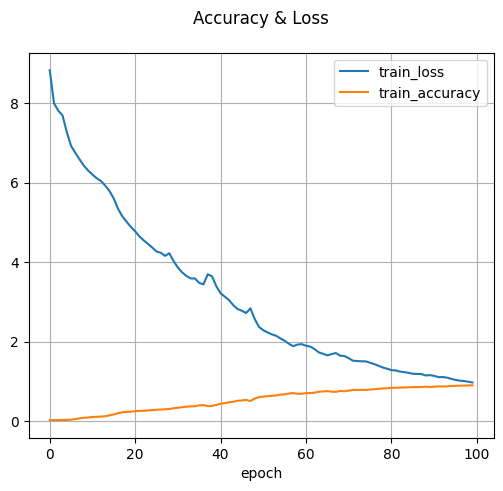

In [36]:
chart.plot_loss_acc(history)

Сброс состояния модели:

In [37]:
model.reset_states()

---

### 3.5 Генерация текста

Выведение на экран результата предсказаний:

In [38]:
pred.predict_next(
    sample='гарри поттер', 
    model=model,
    tokenizer=tokenizer_word_to_index,
    vocabulary=tokenizer_index_to_word,
    n_next=100, 
    temperature=0.6,
    batch_size=BATCH_SIZE,
    word=True
)

'гарри поттер сделать весьма требовалось верёвку, с том, так не глупо летящий верёвку, на фигуры верёвку, в фигуры даже даже даже вы взялась успеха верёвку, элизером элизером окажется отдельно распрямив так в опасен на фигуры если на связать так на фигуры верёвку, летящий на фигуры верёвку, верёвку, элизером даже даже отставал на фигуры даже даже даже если на поприще верёвку, на фигуры даже опасен на фигуры даже верёвку, летящий на даже даже сняты эхом так продолжала у верёвку, на фигуры верёвку, на фигуры верёвку, отдельно у вы взялась объявление, летящий даже даже докажет, летящий на фигуры даже даже даже если я продолжала'

Выведение на экран результата предсказаний:

In [39]:
pred.predict_next(
    sample='однажды в хогвартсе', 
    model=model,
    tokenizer=tokenizer_word_to_index,
    vocabulary=tokenizer_index_to_word,
    n_next=100, 
    temperature=0.8,
    batch_size=BATCH_SIZE,
    word=True
)

'однажды в хогвартсе фигуры даже так продолжала и даже даже даже даже так продолжала на фигуры даже так продолжала и даже даже даже сняты я ещё объявление, летящий на фигуры так верёвку, на верёвку, на фигуры верёвку, на фигуры даже вы сказано так на поприще верёвку, в фигуры даже даже даже только источник летящий на фигуры даже даже так он докажет, успеха воистину, дурака, даже даже так не ушло на никакого числе так летящий летящий на даже даже сняты летящий на духе успеха летящий даже даже вы разрешаю авторитетного стыдно украдут успеха верёвку, верёвку, на фигуры верёвку, разговор, так даже даже же расплавить'

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

Результаты проведённого эксперимента откровенно плохи - модель "заговаривается" и повторяется, но их можно улучшить за счёт усложения модели посредством изменения её слоёв, и в особенности большего числа итераций обучения при наличии соответствующих технических средств.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>